# Modeling TRISO Particles
OpenMC includes a few convenience functions for generationing TRISO particle locations and placing them in a lattice. To be clear, this capability is not a stochastic geometry capability like that included in MCNP. It's also important to note that OpenMC does not use delta tracking, which would normally speed up calculations in geometries with tons of surfaces and cells. However, the computational burden can be eased by placing TRISO particles in a lattice.

In [1]:
%matplotlib inline
from math import pi
import numpy as np
import matplotlib.pyplot as plt
import openmc
import openmc.model

Let's first start by creating materials that will be used in our TRISO particles and the background material.

In [2]:
fuel = openmc.Material(name='Fuel')
fuel.set_density('g/cm3', 10.5)
fuel.add_nuclide('U235', 4.6716e-02)
fuel.add_nuclide('U238', 2.8697e-01)
fuel.add_nuclide('O16',  5.0000e-01)
fuel.add_element('C', 1.6667e-01)

buff = openmc.Material(name='Buffer')
buff.set_density('g/cm3', 1.0)
buff.add_element('C', 1.0)
buff.add_s_alpha_beta('c_Graphite')

PyC1 = openmc.Material(name='PyC1')
PyC1.set_density('g/cm3', 1.9)
PyC1.add_element('C', 1.0)
PyC1.add_s_alpha_beta('c_Graphite')

PyC2 = openmc.Material(name='PyC2')
PyC2.set_density('g/cm3', 1.87)
PyC2.add_element('C', 1.0)
PyC2.add_s_alpha_beta('c_Graphite')

SiC = openmc.Material(name='SiC')
SiC.set_density('g/cm3', 3.2)
SiC.add_element('C', 0.5)
SiC.add_element('Si', 0.5)

graphite = openmc.Material()
graphite.set_density('g/cm3', 1.1995)
graphite.add_element('C', 1.0)
graphite.add_s_alpha_beta('c_Graphite')

To actually create individual TRISO particles, we first need to create a universe that will be used within each particle. The reason we use the same universe for each TRISO particle is to reduce the total number of cells/surfaces needed which can substantially improve performance over using unique cells/surfaces in each.

In [3]:
# Create TRISO universe
spheres = [openmc.Sphere(r=1e-4*r)
           for r in [215., 315., 350., 385.]]
cells = [openmc.Cell(fill=fuel, region=-spheres[0]),
         openmc.Cell(fill=buff, region=+spheres[0] & -spheres[1]),
         openmc.Cell(fill=PyC1, region=+spheres[1] & -spheres[2]),
         openmc.Cell(fill=SiC, region=+spheres[2] & -spheres[3]),
         openmc.Cell(fill=PyC2, region=+spheres[3])]
triso_univ = openmc.Universe(cells=cells)

Next, we need a region to pack the TRISO particles in. We will use a 1 cm x 1 cm x 1 cm box centered at the origin.

In [4]:
min_x = openmc.XPlane(x0=-0.5, boundary_type='reflective')
max_x = openmc.XPlane(x0=0.5, boundary_type='reflective')
min_y = openmc.YPlane(y0=-0.5, boundary_type='reflective')
max_y = openmc.YPlane(y0=0.5, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-0.5, boundary_type='reflective')
max_z = openmc.ZPlane(z0=0.5, boundary_type='reflective')
region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

Now we need to randomly select locations for the TRISO particles. In this example, we will select locations at random within the box with a packing fraction of 30%. Note that `pack_spheres` can handle up to the theoretical maximum of 60% (it will just be slow).

In [5]:
outer_radius = 425.*1e-4
centers = openmc.model.pack_spheres(radius=outer_radius, region=region, pf=0.3)

Now that we have the locations of the TRISO particles determined and a universe that can be used for each particle, we can create the TRISO particles.

In [6]:
trisos = [openmc.model.TRISO(outer_radius, triso_univ, center) for center in centers]

Each TRISO object actually **is** a Cell, in fact; we can look at the properties of the TRISO just as we would a cell:

In [7]:
print(trisos[0])

Cell
	ID             =	6
	Name           =	
	Fill           =	1
	Region         =	-11
	Rotation       =	None
	Translation    =	[-0.33455672  0.31790187  0.24135378]
	Volume         =	None



Let's confirm that all our TRISO particles are within the box.

In [8]:
centers = np.vstack([triso.center for triso in trisos])
print(centers.min(axis=0))
print(centers.max(axis=0))

[-0.45718713 -0.45730405 -0.45725048]
[0.45705454 0.45743843 0.45741142]


We can also look at what the actual packing fraction turned out to be:

In [9]:
len(trisos)*4/3*pi*outer_radius**3

0.2996893513959326

Now that we have our TRISO particles created, we need to place them in a lattice to provide optimal tracking performance in OpenMC. We can use the box we created above to place the lattice in. Actually creating a lattice containing TRISO particles can be done with the `model.create_triso_lattice()` function. This function requires that we give it a list of TRISO particles, the lower-left coordinates of the lattice, the pitch of each lattice cell, the overall shape of the lattice (number of cells in each direction), and a background material.

In [10]:
box = openmc.Cell(region=region)
lower_left, upper_right = box.region.bounding_box
shape = (9, 9, 9)
pitch = (upper_right - lower_left)/shape
lattice = openmc.model.create_triso_lattice(
    trisos, lower_left, pitch, shape, graphite)

Now we can set the fill of our box cell to be the lattice:

In [11]:
box.fill = lattice

Finally, let's take a look at our geometry by putting the box in a universe and plotting it. We're going to use the Fortran-side plotter since it's much faster.

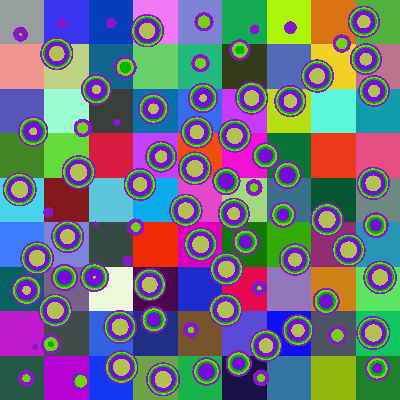

In [12]:
universe = openmc.Universe(cells=[box])

geometry = openmc.Geometry(universe)
geometry.export_to_xml()

materials = list(geometry.get_all_materials().values())
openmc.Materials(materials).export_to_xml()

settings = openmc.Settings()
settings.run_mode = 'plot'
settings.source_mesh = None
settings.export_to_xml()


plot = openmc.Plot.from_geometry(geometry)
plot.to_ipython_image()

In [13]:
!wc -l geometry.xml

10009 geometry.xml


If we plot the universe by material rather than by cell, we can see that the entire background is just graphite.

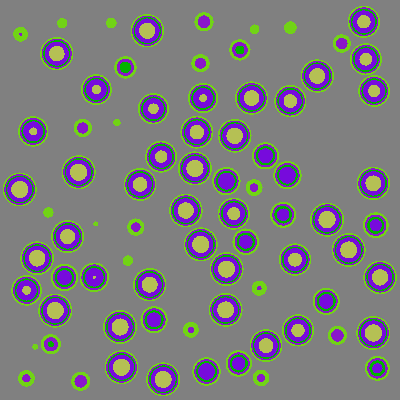

In [14]:
plot.color_by = 'material'
plot.colors = {graphite: 'gray'}
plot.to_ipython_image()

# END OF ORIGINAL NOTEBOOK

In [15]:
fuel_cell = cells[0]
print(fuel_cell.fill)
fuel_mat = fuel_cell.fill

Material
	ID             =	1
	Name           =	Fuel
	Temperature    =	None
	Density        =	10.5 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	U235           =	0.046716     [ao]
	U238           =	0.28697      [ao]
	O16            =	0.5          [ao]
	C0             =	0.16667      [ao]



In [16]:
geometry.determine_paths()

In [17]:
inst_per_compact = fuel_cell.num_instances

In [18]:
# noting that the number of instances is not the same as the number of TRISOs
len(trisos)

932

In [19]:
# create a lattice to place our "compacts" into
upper_lattice = openmc.RectLattice()
upper_lattice.pitch = (1.0, 1.0)
upper_lattice.lower_left = (-0.5, -0.5)
upper_lattice.universes = [[universe, universe], [universe, universe]]

In [20]:
# create a bounding cell for the lattice, variable name mashing because I'm lazy
min_x = openmc.XPlane(x0=-0.5, boundary_type='reflective')
max_x = openmc.XPlane(x0=1.5, boundary_type='reflective')
min_y = openmc.YPlane(y0=-0.5, boundary_type='reflective')
max_y = openmc.YPlane(y0=1.5, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-0.5, boundary_type='reflective')
max_z = openmc.ZPlane(z0=0.5, boundary_type='reflective')
upper_region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

In [21]:
# upper level cell and root universe
upper_cell = openmc.Cell(fill=upper_lattice)
root_univ = openmc.Universe(cells=[upper_cell])

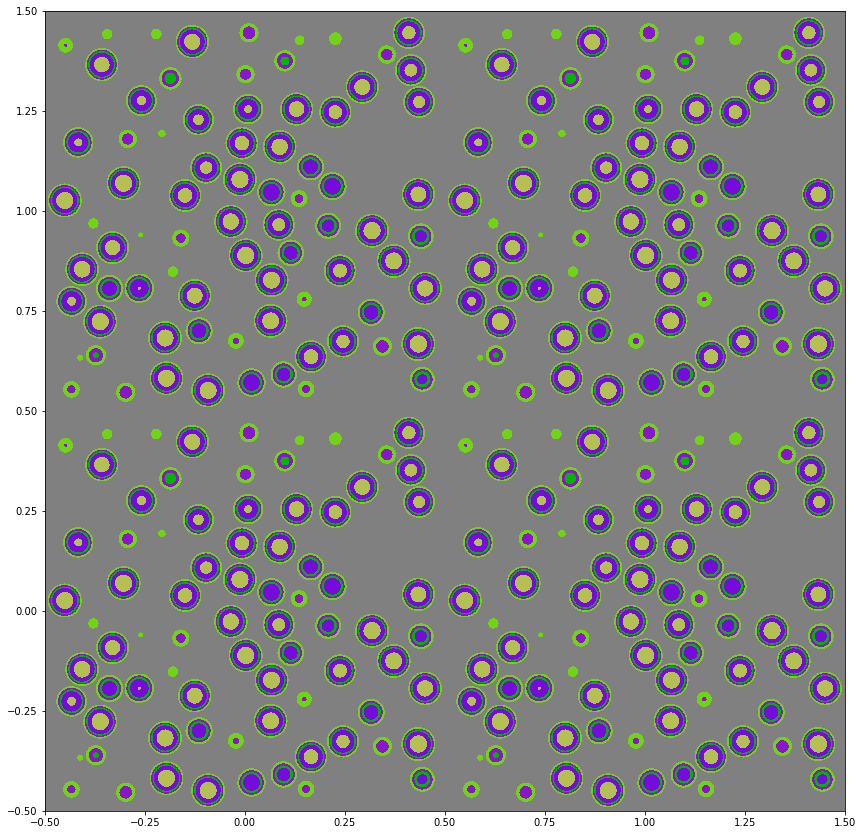

In [22]:
root_univ.plot(width=(2, 2), origin=(0.5, 0.5, 0.0), pixels=(800, 800), color_by='material', colors={graphite: 'gray'})

In [23]:
geometry = openmc.Geometry(root=root_univ)

In [24]:
# clone fuel materials and create material array for fuel cell
mats = []
for i in range(4):
    new_fuel = fuel_mat.clone()
    mats += inst_per_compact * [new_fuel]
fuel_cell.fill = mats

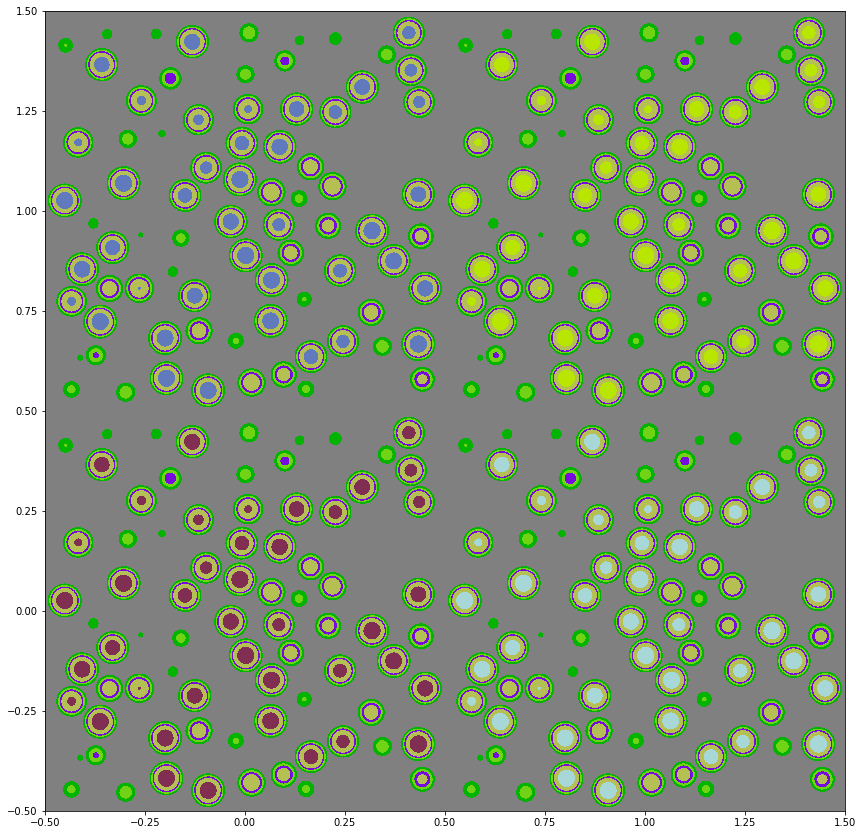

In [25]:
root_univ.plot(width=(2, 2), origin=(0.5, 0.5, 0.0), pixels=(800, 800), color_by='material', colors={graphite: 'grey'})

In [26]:
geometry.export_to_xml()

In [27]:
!wc -l geometry.xml

10018 geometry.xml
